# Spotify Sequential Skip Prediction Challenge

### Anna Martignano, Daniele Montesi, ID2223
With  this  project  we  would  like  to  use  Deep  Learning  to  model  a  solution  to  the  challenge  ”  Spotify Sequential  Skip  Prediction  Challenge  -  Predict  if  users  will  skip  or  listen  to  the  music  they’re  streamed” published by Spotify in collaboration with WSDM and CrowdAI.

Citing the CrowdAI Challenge Website:The task is to predict whether individual tracks encountered in a listening session will beskippedby a particular user.  In order to do this, complete information about the first half of a user’slistening session is provided, while the prediction is to be carried out on the second half.  

The output of a prediction is abinary variable for each track in the second half of the session indicating if it was skipped or not, with a 1 indicating that the track skipped, and a 0 indicating that the track was not skipped.The  problem  corresponds  hence  to  a  binary  classification.   However,  the  problem  is  hard  and  must take into account all the history of the user tracks listened, making the model that best fits this problem aRecurrent Neural Networks.


### Code organization

The Project will present the following sections:

1. Data exploration 
2. Data filtering/preprocessing 
3. Dataset creation
4. Model reasoning and creation and fitting
5. Model validation: Cross-validation with k=5 folds
6. Further feature extraction and further model improvement

We will divide the work into 3 notebooks:

1. **Data Exploration of the Dataset**
See the main features, have an idea of what's the goal of the project

2. **Dataset creation:**
Comprises: Data filtering/preprocessing & Dataset creation

3. **Model Creation and Fitting**
Comprises the model creation and fitting. \
It will be done in Google Colab in order to make use of a GPU

4. **Feature Extraction & Improvement**

## 1 - Data Exploration

Let's perform basic data esploraton to see which types of columns to leave/to remove

We will start form the **session dataset:**

In [5]:
import os
from tqdm import tqdm
import numpy as np
import pandas as pd
from glob import glob
from joblib import delayed, Parallel
import matplotlib.pyplot as plt
import datetime
from sklearn.preprocessing import LabelEncoder, StandardScaler
%matplotlib inline
pd.set_option('display.max_columns', 500)

path = "dataset/"

The dataset is made of the first 6 csv blocks provided by AICrowd. 
Each block is ~500MB size csv. For sake of brevity, we only explore one small dataset block here.

Let's now explore the first block and how it does look like:

In [6]:
data = pd.DataFrame()

for i in [1]:
  data = pd.concat([data, pd.read_csv(path+"/{}.csv".format(i))])

data.reset_index(drop=True, inplace=True)

In [7]:
data.head(5)

,session_id,session_position,session_length,track_id_clean,skip_1,skip_2,skip_3,not_skipped,context_switch,no_pause_before_play,short_pause_before_play,long_pause_before_play,hist_user_behavior_n_seekfwd,hist_user_behavior_n_seekback,hist_user_behavior_is_shuffle,hour_of_day,date,premium,context_type,hist_user_behavior_reason_start,hist_user_behavior_reason_end
0,0_00006f66-33e5-4de7-a324-2d18e439fc1e,1,20,t_0479f24c-27d2-46d6-a00c-7ec928f2b539,False,False,False,True,0,0,0,0,0,0,True,16,2018-07-15,True,editorial_playlist,trackdone,trackdone
1,0_00006f66-33e5-4de7-a324-2d18e439fc1e,2,20,t_9099cd7b-c238-47b7-9381-f23f2c1d1043,False,False,False,True,0,1,0,0,0,0,True,16,2018-07-15,True,editorial_playlist,trackdone,trackdone
2,0_00006f66-33e5-4de7-a324-2d18e439fc1e,3,20,t_fc5df5ba-5396-49a7-8b29-35d0d28249e0,False,False,False,True,0,1,0,0,0,0,True,16,2018-07-15,True,editorial_playlist,trackdone,trackdone
3,0_00006f66-33e5-4de7-a324-2d18e439fc1e,4,20,t_23cff8d6-d874-4b20-83dc-94e450e8aa20,False,False,False,True,0,1,0,0,0,0,True,16,2018-07-15,True,editorial_playlist,trackdone,trackdone
4,0_00006f66-33e5-4de7-a324-2d18e439fc1e,5,20,t_64f3743c-f624-46bb-a579-0f3f9a07a123,False,False,False,True,0,1,0,0,0,0,True,16,2018-07-15,True,editorial_playlist,trackdone,trackdone


### Feature Session Length

10    0.048739
11    0.047673
12    0.045390
13    0.043300
14    0.041411
15    0.039418
16    0.036413
17    0.034743
18    0.032688
19    0.030534
20    0.599691
Name: session_length, dtype: float64


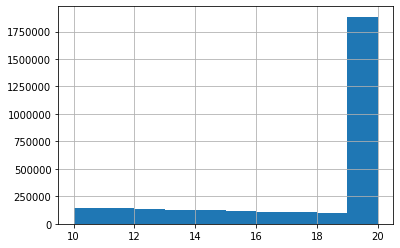

In [8]:
print(data.session_length.value_counts(normalize=True, sort=False))
data.session_length.hist()

### Feature Skip_2

Actually is 50-50 - Balanced dataset!

False    0.48725
True     0.51275
Name: skip_2, dtype: float64


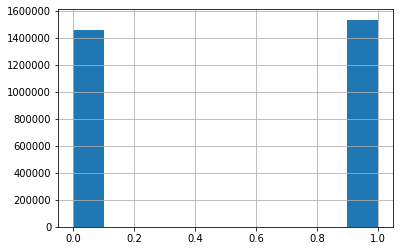

In [9]:
print(data.skip_2.value_counts(normalize=True, sort=False))
data.skip_2.astype(np.int).hist()

In [10]:
data.hist_user_behavior_reason_start.value_counts(normalize=True, sort=False)

appload       1.153377e-02
fwdbtn        4.734962e-01
popup         1.671900e-06
trackdone     3.321474e-01
trackerror    5.711211e-04
backbtn       7.584342e-02
remote        9.048324e-04
endplay       1.307426e-04
playbtn       9.309141e-04
clickrow      1.044396e-01
uriopen       3.343801e-07
Name: hist_user_behavior_reason_start, dtype: float64

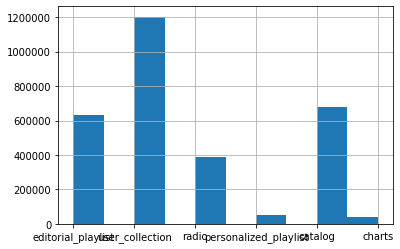

In [11]:
data.context_type.hist()

In [12]:
data.no_pause_before_play.value_counts(normalize=True, sort=False)

0    0.233387
1    0.766613
Name: no_pause_before_play, dtype: float64

# Feature Premium or not

Premium ~ 5 times more than others

True     2419034
False     571575
Name: premium, dtype: int64


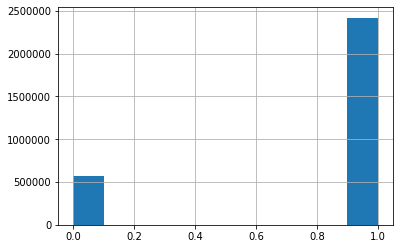

In [13]:
print(data.premium.value_counts())
data.premium.astype(np.int).hist()

## Feature Hour of day

We will consier the hour for every day period (i.e. nightmorning/afternoon) to reduce number of categories

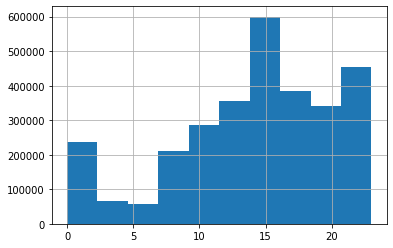

In [14]:
data.hour_of_day.hist()

In [15]:
data.describe()

,session_position,session_length,context_switch,no_pause_before_play,short_pause_before_play,long_pause_before_play,hist_user_behavior_n_seekfwd,hist_user_behavior_n_seekback,hour_of_day
count,2.990609e+06,2.990609e+06,2.990609e+06,2.990609e+06,2.990609e+06,2.990609e+06,2.990609e+06,2.990609e+06,2.990609e+06
mean,9.312991e+00,1.762598e+01,4.242681e-02,7.666128e-01,1.473198e-01,1.737532e-01,3.958525e-02,4.301465e-02,1.413181e+01
std,5.449092e+00,3.414523e+00,2.015609e-01,4.229866e-01,3.544245e-01,3.788972e-01,3.620769e-01,5.537631e-01,6.036343e+00
min,1.000000e+00,1.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,5.000000e+00,1.500000e+01,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.100000e+01
50%,9.000000e+00,2.000000e+01,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.500000e+01
75%,1.400000e+01,2.000000e+01,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.900000e+01
max,2.000000e+01,2.000000e+01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,2.120000e+02,4.380000e+02,2.300000e+01


## Feature exploration: Duplicate songs suggested within a session

If interesting, we are then going to feature-engineer those interesting features, and we log-normalised the last feature in order to alleviate the long tail distribution.

Results:
- 54.8 % sessions presenting at least a duplicate track suggested
- On avg, there are 2.15

In [16]:
# Check for presence of duplicate tracks into a session
grouped_sess_tracks = data.groupby('session_id')['track_id_clean'].apply(lambda x: x.tolist()).tolist()

In [17]:
dict_dup_tracks = {}

dup_track_in_sess = 0
dup = 0

idx = 0
for list_tracks in tqdm(grouped_sess_tracks):
    curr_sess = data.at[idx, "session_id"]
    dict_dup_tracks[curr_sess] = {}
    
    tot_len = len(list_tracks)
    len_set = len(set(list_tracks))
    if tot_len > len_set:
        dup_track_in_sess += 1
        dup += tot_len-len_set
        
    for track in list_tracks:
        if dict_dup_tracks.get(track) == None:
            dict_dup_tracks[curr_sess][track] = 1
        else:
            dict_dup_tracks[curr_sess][track] +=1
            
    idx += tot_len
    
print("There are", dup_track_in_sess*100/len(grouped_sess_tracks), "% sessions presenting at least a duplicate track suggested")

print("On avg, there are", dup/len(grouped_sess_tracks), "duplicate songs in those sessions")

100%|██████████| 178342/178342 [00:06<00:00, 26297.14it/s]

There are 55.046483722286396 % sessions presenting at least a duplicate track suggested
On avg, there are 2.1305805699162286 duplicate songs in those sessions


55% of sessions are recommended a track multiple times. It will be interesting to add this feature in the future processing of data

In [18]:
for i in tqdm(data.index):
    data.at[i, 'duplicated_time'] = dict_dup_tracks[data.at[i, 'session_id']][data.at[i, 'track_id_clean']]

100%|██████████| 2990609/2990609 [03:21<00:00, 14870.75it/s]


# 2 - Tracks dataset:

Also, let's load the Tracks features and explore them


In [19]:
tf = pd.read_csv(path+"tf_1.csv")
tf = pd.concat([tf, pd.read_csv(path+"tf_2.csv")])
tf.reset_index(drop=True, inplace=True)

In [20]:
tf.sample(5)

,track_id,duration,release_year,us_popularity_estimate,acousticness,beat_strength,bounciness,danceability,dyn_range_mean,energy,flatness,instrumentalness,key,liveness,loudness,mechanism,mode,organism,speechiness,tempo,time_signature,valence,acoustic_vector_0,acoustic_vector_1,acoustic_vector_2,acoustic_vector_3,acoustic_vector_4,acoustic_vector_5,acoustic_vector_6,acoustic_vector_7
771158,t_f7b534df-ffff-4154-a9a7-27b1c56cd9a4,98.439369,2018,92.260911,0.532357,0.337667,0.374122,0.430921,6.772919,0.541588,1.019660,1.372499e-10,4,0.132947,-6.390,0.644951,major,0.452473,0.032722,207.912994,4,0.961253,-0.156259,-0.026736,0.159661,0.640426,0.561342,-0.346066,0.777637,-0.487515
3008398,t_93de2cc2-6435-4f3f-a964-274af43e1417,259.928558,2011,91.819903,0.401643,0.483044,0.578797,0.603090,9.248159,0.797024,0.978735,2.130483e-11,7,0.146153,-7.249,0.487562,major,0.460385,0.285161,162.703003,4,0.685245,-0.928034,0.400092,0.211792,0.257799,-0.103636,-0.056839,-0.123954,0.271191
886447,t_a8f7f64b-7e63-4fca-8cd3-146d803f6a89,189.226669,2015,93.551876,0.139832,0.654339,0.746258,0.756340,11.669786,0.630127,0.960493,1.758381e-10,5,0.060543,-9.027,0.809619,minor,0.167030,0.358204,179.817001,4,0.672185,-0.922785,0.281562,0.199728,0.165358,-0.330559,-0.078307,-0.601725,0.157073
1058426,t_4266c435-1cbf-4470-a9e2-f79fc00d8b29,175.666672,1982,98.028147,0.000325,0.354906,0.379362,0.331099,6.729368,0.836294,0.944988,6.021954e-03,7,0.251502,-8.822,0.348889,major,0.460405,0.169188,174.513000,4,0.529885,0.108031,0.037404,-0.399949,-0.281952,0.517134,0.026824,-0.282128,0.180099
1941135,t_60da5ed3-28b2-42a1-9701-74732da8ef6f,130.057144,2011,91.524936,0.903287,0.645719,0.787043,0.694640,13.664343,0.539836,0.834151,4.258181e-10,0,0.302810,-17.910,0.164384,major,0.870110,0.926276,77.309998,4,0.226343,-0.485463,0.088997,-0.142842,0.095245,-0.157338,-0.324196,-0.443901,-0.283188


## We observe an high presence of features related to the music

- Acoustic vector (there are 8) that are numbers related to rhythm and melody strength/characteristics.
- Some features for the technical music charateritcis (key, tempo)
- Some for the overall characteristics (danceability, energy, ..)

We see that all of them have mean ~ 0, probably stanardized. They will be used to understand which track can be guessed by users.

In [21]:
tf.describe()

,duration,release_year,us_popularity_estimate,acousticness,beat_strength,bounciness,danceability,dyn_range_mean,energy,flatness,instrumentalness,key,liveness,loudness,mechanism,organism,speechiness,tempo,time_signature,valence,acoustic_vector_0,acoustic_vector_1,acoustic_vector_2,acoustic_vector_3,acoustic_vector_4,acoustic_vector_5,acoustic_vector_6,acoustic_vector_7
count,3.706388e+06,3.706388e+06,3.706388e+06,3.706388e+06,3.706388e+06,3.706388e+06,3.706388e+06,3.706388e+06,3.706388e+06,3.706388e+06,3.706388e+06,3.706388e+06,3.706388e+06,3.706388e+06,3.706388e+06,3.706388e+06,3.706388e+06,3.706388e+06,3.706388e+06,3.706388e+06,3.706388e+06,3.706388e+06,3.706388e+06,3.706388e+06,3.706388e+06,3.706388e+06,3.706388e+06,3.706388e+06
mean,2.331915e+02,2.009261e+03,9.557394e+01,3.469715e-01,4.617475e-01,4.791122e-01,5.565486e-01,7.848266e+00,5.918491e-01,9.934531e-01,2.070054e-01,5.272434e+00,2.126515e-01,-9.604988e+00,4.996207e-01,4.618936e-01,1.045310e-01,1.200684e+02,3.874560e+00,4.814764e-01,-1.044815e-01,1.553606e-02,5.953425e-02,5.320778e-02,2.273738e-02,6.459076e-04,-2.493560e-02,-1.594925e-03
std,1.084008e+02,1.103289e+01,2.735566e+00,3.426439e-01,1.717593e-01,1.990264e-01,1.858440e-01,2.680296e+00,2.602815e-01,5.521685e-02,3.447905e-01,3.564020e+00,1.924461e-01,5.732654e+00,2.561809e-01,2.509198e-01,1.385980e-01,3.042757e+01,4.851897e-01,2.725142e-01,4.323750e-01,3.607428e-01,2.804066e-01,3.821163e-01,4.107566e-01,2.118570e-01,3.742747e-01,3.871178e-01
min,3.000095e+01,1.950000e+03,9.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-6.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.174042e+00,-1.185975e+00,-8.858698e-01,-8.994451e-01,-1.081056e+00,-1.063290e+00,-8.022487e-01,-1.178501e+00
25%,1.767467e+02,2.006000e+03,9.338183e+01,2.667680e-02,3.316528e-01,3.206987e-01,4.326980e-01,5.821963e+00,4.098319e-01,9.691408e-01,2.465405e-07,2.000000e+00,9.680310e-02,-1.171000e+01,2.692308e-01,2.532349e-01,3.627243e-02,9.603400e+01,4.000000e+00,2.519543e-01,-4.085117e-01,-1.757177e-01,-1.471524e-01,-2.348342e-01,-3.122829e-01,-9.018810e-02,-3.155564e-01,-2.704680e-01
50%,2.179135e+02,2.013000e+03,9.575417e+01,2.205129e-01,4.593159e-01,4.795972e-01,5.727441e-01,7.519920e+00,6.261150e-01,1.002422e+00,2.161874e-04,5.000000e+00,1.294195e-01,-8.084000e+00,4.854369e-01,4.549237e-01,5.012670e-02,1.199480e+02,4.000000e+00,4.736025e-01,-4.000132e-02,8.460746e-02,1.291028e-01,6.207571e-02,-1.709655e-02,4.277601e-02,-9.838638e-02,-4.027091e-03
75%,2.671733e+02,2.017000e+03,9.792122e+01,6.528423e-01,5.851562e-01,6.339014e-01,6.975901e-01,9.476902e+00,8.073052e-01,1.029172e+00,3.132863e-01,8.000000e+00,2.700362e-01,-5.791000e+00,7.173145e-01,6.480055e-01,1.015356e-01,1.398600e+02,4.000000e+00,7.050039e-01,1.915962e-01,2.832876e-01,2.746523e-01,2.832823e-01,3.724048e-01,1.476096e-01,2.058770e-01,2.218316e-01
max,1.799999e+03,2.019000e+03,1.000000e+02,9.957964e-01,9.999525e-01,9.862775e-01,9.978067e-01,5.261309e+01,9.999841e-01,1.167801e+00,9.999964e-01,1.100000e+01,1.000000e+00,6.275000e+00,1.000000e+00,9.791129e-01,9.705799e-01,2.499870e+02,5.000000e+00,9.999900e-01,1.000457e+00,8.624035e-01,6.509755e-01,1.202726e+00,1.000955e+00,4.130149e-01,1.092165e+00,1.204228e+00


Total durations are 1006437
233.19145037273267


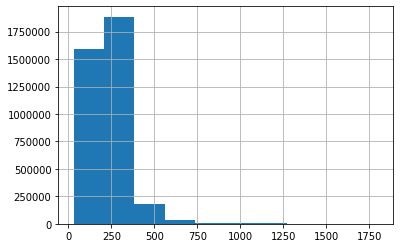

In [22]:
tf.duration.hist();
print("Total durations are", len(set(tf.duration)))
print(np.mean(tf.duration.values))

### Release year of the song.
We expect an exponential curve, being songs released nowadays many more than before!

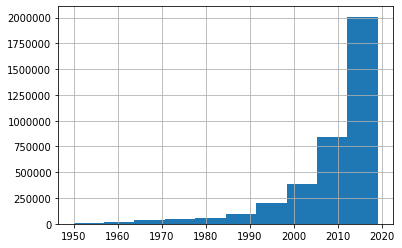

In [23]:
tf.release_year.hist();
# Similar to inverse power law distribution :)

### US popularity  of the song.
Spotify estimates the popularity by the listens a song obtains. We are quite focused on US as we can see...

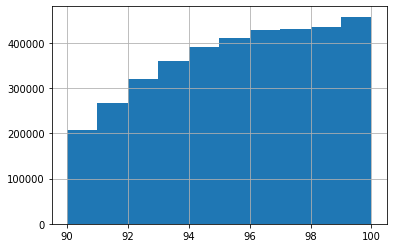

In [24]:
tf.us_popularity_estimate.hist();

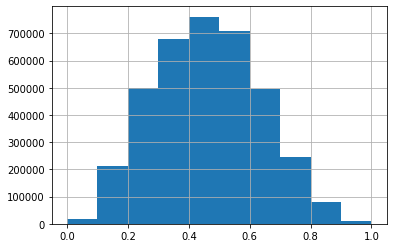

In [25]:
tf.beat_strength.hist();
# So that's a case of gaussian distribution :)

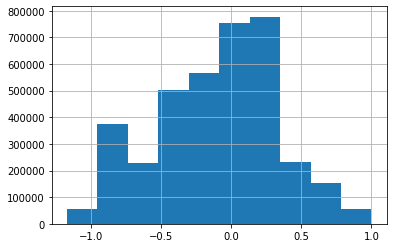

In [26]:
tf.acoustic_vector_0.hist();

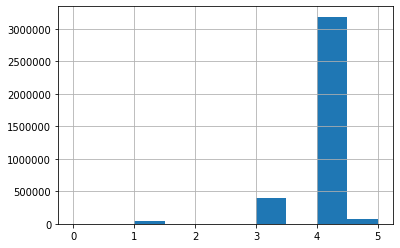

In [27]:
tf.time_signature.hist()

In [28]:
tf.time_signature.value_counts()

4    3186542
3     393780
5      77590
1      45164
0       3312
Name: time_signature, dtype: int64

# 2- Dataset Preprocessing

As we can see, the dataset is made of these columns:

- SessionPosition: the position of the track on the session (which can be long up to 20)
- skip_1	skip_2	skip_3	not_skipped: The possible values for skipping. For this purpose, we will drop all of these except for the skip_2, which is the type of skip we are interested on

In [29]:
data["label"] = data["skip_2"]
data.drop(['skip_1', 'skip_2','skip_3', 'not_skipped'], axis=1, inplace=True)

### Feature Engineering:  
- hour of day -> only 4 values: night-morning-after-evening
- session length - max - med - low


# Reduce the number of features

According to many papers, session_length is a very interesting festures and sessions having lenght = 20 (the max) and other lenght behaves very ifferently. We hence decided to put the feature as **Categorical** and to reduce the number of possible choices. We iterate over the dataframe and used the followint assignment:

Same happens for hour_of_day to distinguish afternoon-evening-morning and release year

In [30]:
for i in tqdm(data.index):
    leng = int(data.at[i, "session_length"])
    hour = int(data.at[i, "hour_of_day"])
    if leng < 15:
        data.at[i, "session_length"] = 0
    elif leng >= 15 and leng<20:
        data.at[i, "session_length"] = 1
    else:
        data.at[i, "session_length"] = 2
        
        
    if hour >7 and hour<=13:
        hour = data.at[i, "hour_of_day"] = 0
    elif hour >13 and hour<20:
        hour = data.at[i, "hour_of_day"] = 1
    elif hour >=20:
        hour = data.at[i, "hour_of_day"] = 2
    else:
        hour = data.at[i, "hour_of_day"] = 3
        

        

100%|██████████| 2990609/2990609 [04:15<00:00, 11702.16it/s]


In [31]:
for i in tqdm(tf.index):
    yr = int(tf.at[i, "release_year"])
    if yr < 1960:
        tf.at[i, "release_year"] = 0
    elif yr >= 1960 and yr < 1970:
        tf.at[i, "release_year"] = 1
    elif yr > 1970 and yr <= 1980:
        tf.at[i, "release_year"] = 2
    elif yr > 1980 and yr <= 1990:
        tf.at[i, "release_year"] = 3
    elif yr > 1990 and yr <= 2000:
        tf.at[i, "release_year"] = 4
    elif yr > 2000 and yr <= 2005:
        tf.at[i, "release_year"] = 5
    elif yr > 2005 and yr <= 2010:
        tf.at[i, "release_year"] = 6
    elif yr > 2010 and yr <= 2015:
        tf.at[i, "release_year"] = 7
        

100%|██████████| 3706388/3706388 [02:09<00:00, 28614.04it/s]
